## Comparing clustering results

This brings together some topic covered already and expands on them with a way to determine a metric of similarity for corresponding clusters from different sources.

### Setting up different sources

For preparing data to compare want slightly different assignments, we want two different results. 

Will use Hierarchical Clustering with assigned 'wrong' number of clusters, four when it should be three, from the bottom of [Hierarchical_clustering.ipynb](Hierarchical_clustering.ipynb).

Note that the 'membership report' has been left off the output here for brevity. Later, using a membership report to get data needed for calculating `sklearn.metrics.adjusted_rand_score()` for comparing the results of clustering is covered and how to get that report will be recalled there.

In [1]:
import seaborn as sns
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
        
    based on https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
    and converted to using Seaborn 
    and adding plotting only lower triangular of the matrix
    by Wayne 6-10-2020
    '''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr_df = df.corr()
    
    # make the mask based on https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/
    mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
    #print( mask_ut)  # FOR DEBUGGING
    
    # Plot the correlation matrix
    '''
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    '''
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size+2, size))
    sns.heatmap(corr_df, mask=mask_ut, cmap="RdYlGn")
    
import pandas as pd
import numpy as np

# Generate 50 variables with 1000 samples
n_variables = 50
n_samples = 1000

# Those variables will be spread over 3 clusters of variable sizes
cluster_size = [5,22,28]
n_clusters = len(cluster_size)

# Assign each variable to a cluster
belongs_to_cluster = [i for i, c in enumerate(cluster_size) for n in range(c)]
np.random.shuffle(belongs_to_cluster)

# This latent data is used to make variables that belong
# to the same cluster correlated.
latent = np.random.randn(n_clusters, n_samples)

variables = []
for i in range(n_variables):
    variables.append(np.random.randn(n_samples) + latent[belongs_to_cluster[i], :])

df = pd.DataFrame(np.array(variables).transpose())

Example using first-pass example (fifth code cell if running notebook linearly) from above to specify four clusters:

In [2]:
import scipy
import scipy.cluster.hierarchy as sch


X = df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
k = 4
ind = sch.fcluster(L, k, criterion='maxclust')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df_clustered_hc = df.reindex(columns, axis=1) # this line updated from source because `df.reindex_axis()` deprecated

print("number of clusters determined:",len(np.unique(ind)))
for x in np.unique(ind):
    class_members = [xc for xc in ind if xc == x]
    print(f"{len(class_members)} variables in cluster {x}")

clusterBYindex = zip(ind.tolist(),df.columns)
from collections import defaultdict 
cluster_assignments_hc = defaultdict(list)
for x in clusterBYindex:
    cluster_assignments_hc[x[0]].append(x[1])
    
#plot_corr(df_clustered_hc, size=10)

number of clusters determined: 4
24 variables in cluster 1
5 variables in cluster 2
11 variables in cluster 3
10 variables in cluster 4


Use DBSCAN clustering result to produce another result.

In [3]:
import scipy
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from sklearn import metrics


dfX = df.corr().values
X = metrics.pairwise_distances(dfX) 


db = DBSCAN(eps=2.1, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#print(labels)  #FOR DEBUGGING

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

labels_true = False
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
for x in np.unique(labels):
    class_members = [xc for xc in labels if xc == x]
    print(f"{len(class_members)} variables in grouping {x}")
# Membership report-lite (based on code first worked out under 
# 'Obtaining and viewing the cluster membership without the rest of plot' section of 
# my notebook `Correlation matrix clustering featuring heatmap plot with seaborn.ipynb`.)
clusterBYindex = zip(labels.tolist(),df.columns)
from collections import defaultdict 
cluster_assignments_db = defaultdict(list)
for x in clusterBYindex:
    cluster_assignments_db[x[0]].append(x[1])
'''
print("Cluster breakdown:")
for k,v in cluster_assignments_db.items():
    print(f"The {len(v)} members of cluster {k} are: {v}")
    print(f"The SORTED {len(v)} members of cluster {k} are: {sorted(v)}")
'''

columns = [df.columns.tolist()[i] for i in list((np.argsort(labels)))]
df_clustered_db = df.reindex(columns, axis=1) # this line updated from source because `df.reindex_axis()` deprecated
#plot_corr(df_clustered_db, size=10)

Estimated number of clusters: 3
Estimated number of noise points: 0
21 variables in grouping 0
24 variables in grouping 1
5 variables in grouping 2


### Compare clustering results from the two different approaches

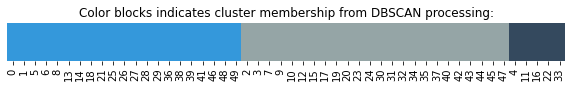

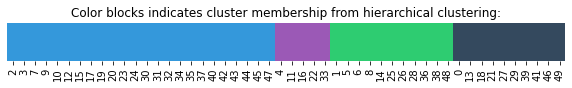

In [4]:
# Visualize members for each
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for DBSCAN
data4df = labels
df4view = pd.DataFrame(data4df)  #<--- note DO NOT USE `pd.DataFrame.from_records` here
df4view = df4view.T
labels4df = sorted(list(df_clustered_db.columns))
df4view.columns = labels4df
df4viewreoriented = df4view.T
df4viewreoriented = df4viewreoriented.rename_axis('sample_ids')
df4viewreoriented.columns = ["cluster_num"]
df4viewreoriented = df4viewreoriented.sort_values(by = ['cluster_num', 'sample_ids'], ascending = [True, True])
df4view = df4viewreoriented.T

# Plot after data preparation
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # from https://seaborn.pydata.org/tutorial/color_palettes.html
flatui = [ "#3498db", "#9b59b6", "#95a5a6", "#2ecc71","#34495e"] # based on https://seaborn.pydata.org/tutorial/color_palettes.html
plt.figure(figsize=(10, 0.7)) #from https://stackoverflow.com/a/55173418/8508004
g = sns.heatmap(df4view, cmap=flatui,cbar=False) # hiding colorbar based 
# on https://stackoverflow.com/q/50454360/8508004

g.set_yticklabels([""]) 
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
)
g.set_xlabel("") # when added column name to make the sorting work I had to then turn off;
# used approach like mentioned above for determining `g.set_yticklabels([""])` above

plt.title("Color blocks indicates cluster membership from DBSCAN processing:");

# Prepare the data for hierarchichal clustering
data4df = ind
df4view = pd.DataFrame(data4df)  #<--- note DO NOT USE `pd.DataFrame.from_records` here
df4view = df4view.T
labels4df = sorted(list(df_clustered_hc.columns))
df4view.columns = labels4df
df4viewreoriented = df4view.T
df4viewreoriented = df4viewreoriented.rename_axis('sample_ids')
df4viewreoriented.columns = ["cluster_num"]
df4viewreoriented = df4viewreoriented.sort_values(by = ['cluster_num', 'sample_ids'], ascending = [True, True])
df4view = df4viewreoriented.T

# Plot after data preparation
plt.figure(figsize=(10, 0.7)) #from https://stackoverflow.com/a/55173418/8508004
g = sns.heatmap(df4view, cmap=flatui,cbar=False) # hiding colorbar based 
# on https://stackoverflow.com/q/50454360/8508004

g.set_yticklabels([""])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
)
g.set_xlabel("")
plt.title("Color blocks indicates cluster membership from hierarchical clustering:");

You can see the difference there but what about metrics/scores that don't make you have to interpret similarity visually?

There is [an evaluation metric](https://stackoverflow.com/a/45090023/8508004) built into scikit-learn, discussed towards the end of the [DBSCAN notebook](dbscan.ipynb) in this series of notebooks, that allows checking the clusters assigned and it will evaluate the assignments as matching, `adjusted_rand_score` of `1.0`, even if the specific cluster number assigned are different, i.e., see the `adjusted_rand_score([0, 0, 1, 1], [1, 1, 0, 0])` example [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html). Let's have it examine the two assignments here.

In [5]:
print(f"The following are the cluster assignments for labels from the DBSCAN result:\n{labels}")
print(f"The following are the cluster assignments for labels from the hierarchichal clustering:\n{ind}")
from sklearn.metrics.cluster import adjusted_rand_score
rand_scor= adjusted_rand_score(labels, ind)
print(f"The result with `adjusted_rand_score()` comparing the assignments:\n{rand_scor}")

The following are the cluster assignments for labels from the DBSCAN result:
[0 0 1 1 2 0 0 1 0 1 1 2 1 0 0 1 2 1 0 1 1 0 2 1 1 0 0 0 0 0 1 1 1 2 1 1 0
 1 0 0 1 0 1 1 1 1 0 1 0 0]
The following are the cluster assignments for labels from the hierarchichal clustering:
[4 3 1 1 2 3 3 1 3 1 1 2 1 4 3 1 2 1 4 1 1 4 2 1 1 3 3 4 3 4 1 1 1 2 1 1 3
 1 3 4 1 4 1 1 1 1 4 1 3 4]
The result with `adjusted_rand_score()` comparing the assignments:
0.8068205603135599


Unlike the case previously shown at the end of  end of the [DBSCAN notebook](dbscan.ipynb) in this series of notebooks, the assignments don't match perfectly, and we see a number less than `1.0`. However, the fact the score isn't close to `0.0` and the score is closer to one means the assignments match fairly well in this example.

Let's get a sense of how the best corresponding clusters are represented among the two clustering results. Running the following cell will make a report detailing this with the DBSCAN results as the first provided set of assignments and the assignments for the 'purposefully-wrong' hierarchical clustering approach:

In [6]:
#BELOW adapted from code that was to be used to check how similar the clustermap 
# labels are and the two-pass clusters direct from SciPy in `Correlation matrix 
# hierarchical clustering featuring heatmap plot with seaborn.ipynb` in my 
# https://github.com/fomightez/cluster_analysis-binder repo, on 7-28-2020 to be 
# used in `Comparing_clusters.ipynb`
# To check how similar the clusters are assigned between to clustering results. 
# I'm going iterate over the clusters in the fist set of data and compare what 
# fraction are represented in the corresponding one from the other set. There 
# can only be one reasonable correspondence, and so the one with the better 
# amount of matches will win out. (You could imagine for comparisons where there
# is a different amont of clusters from each result, that you could allow the a 
# single cluster in one result to have a correspondence with more than one in 
# the other and still score fraction respresented.) For those with no good 
# correspondence, ie., multiple clusters have the same amount ot matches, I'll 
# report that.



def tally_shared_for_cluster(members_list, cluster_assignments):
    '''
    Takes:
    - a list of the members of one cluster
    - cluster assignments dictionary with identifiers as keys and list of 
    corresponding members as value 

    Returns:
    -  A list with number of matches for each cluster in the input cluster 
    assignments.
    '''
    shared = []
    for curr_cluster_members in cluster_assignments.values():
        shared.append(len(set(members_list).intersection(set(curr_cluster_members))))
    return shared

def compare_cluster_membership(cluster_assignmentsA, cluster_assignmentsB):
    '''
    Takes two clusters and compares the fraction of membership represented between 
    best correspondence for each cluster in the first set of assignments provided.

    The cluster assignments are to be provided as dictionaries with the keys as 
    the cluster id and the calues as a list of members.
    '''
    best_correspondence = {}
    score_per_cluster = {}
    cluster_numberings_corresponding_already= []
    results_fractions = []
    results_clusters = []
    poor_clusters = []
    matches_inB_per_cluster_inA = {}
    # Collect number of shared members present in B for each cluster in A
    for cluster_id, cluster_members in cluster_assignmentsA.items():
        # collect the number of shared members in the current cluster in the 
        # assignment from A with ALL the assignments from B. This will be a list
        # for each cluster in cluster_assignmentsA with number of matches to
        # each cluster in cluster_assignmentsB in order, so I can use the index
        # of the match later as it will correspond to the index in 
        #`list(cluster_assignmentsB.items())`, or similar. However, because the
        # dictionary keys can be in any order, convert back to actual key of 
        # assignment using `list(cluster_assignmentsB)[indx]` or similar when 
        # assigning correspondence.
        shared_member_values = tally_shared_for_cluster(
            cluster_members,cluster_assignmentsB)
        matches_inB_per_cluster_inA[cluster_id] = shared_member_values
    # Determine best in B for each cluster in A
    for indx, (cluster_id, cluster_members) in enumerate(
        cluster_assignmentsA.items()):
        match_matrix = np.array(list(matches_inB_per_cluster_inA.values())) #see 
        # following for indexing 2d matrix: 
        #https://thispointer.com/python-numpy-select-rows-columns-by-index-from-a-2d-ndarray-multi-dimension/
        
        # Now go through the tallies and assign best correspondence. This is a 
        # separate iteration over `cluster_assignmentsA.items()` because need 
        # results for each cluster first so don't assign best match for one set of members of assignment A encountered first when there is a better match to that 
        # cluster among assignments A that will be iterated on later.
        #  just because best match first encountered when there may be one later 
        # in elements of `cluster_assignmentsA.items()` that matches better to 
        # that cluster.
        # identify best correspondence. This makes some assumptions:
        # There can only be one reasonable correspondence, and so the one with 
        # the better amount of matches will win out. (You could imagine for 
        # comparisons where there is a different amont of clusters from each 
        # result, that you could allow the a single cluster in one result to 
        # have a correspondence with more than one in the other and still score 
        #fraction respresented.) For those with no good correspondence, ie., 
        # multiple clusters have the same amount ot matches, I'll report that.
        top_matches_for_current_members = max(match_matrix[indx,:])
        if list(match_matrix[indx,:]).count(
            top_matches_for_current_members) == 1:
            # Now make sure for the assignment with that index, there isn't a better
            # option for that cluster in B for a cluster in A
            indx_max = list(match_matrix[indx,:]).index(
                top_matches_for_current_members)
            if (max(match_matrix[:,indx_max]) == top_matches_for_current_members and list(match_matrix[:,indx_max]).count(top_matches_for_current_members) == 1):
                best_correspondence[cluster_id] = list(
                    cluster_assignmentsB)[indx_max]
                # If there is a better option for that cluster in B, try with 
                # second best number of matches and progress cycling to next 
                # best, and again, etc.
            else:
                sorted_row = sorted(list(match_matrix[indx,:])) # based on
                # https://www.geeksforgeeks.org/python-largest-smallest-second-largest-second-smallest-list/ , 
                # but fixed from `list(match_matrix[indx,:]).sort()` to 
                # `sorted(list(match_matrix[indx,:]))` so works on reults of 
                # numpy array slice.
                for x in range (2,len(cluster_assignmentsA)):
                    if len(sorted_row)-x > 0:
                        match_num = sorted_row[len(sorted_row)-x]
                        indx_match_num = list(
                            match_matrix[indx,:]).index(match_num)
                        if (max(match_matrix[:,indx_match_num]) == match_num and list(match_matrix[:,indx_match_num]).count(match_num) == 1):
                                best_correspondence[cluster_id] = list(
                                    cluster_assignmentsB)[indx_match_num]
                                break
                    else:
                        best_correspondence[cluster_id] = "No_good_correspondence"
                        #print(f"There is no correspondence for cluster {cluster_id}.")
                        break
                    best_correspondence[cluster_id] = "No_good_correspondence"
                    #print(f"There is no correspondence for cluster {cluster_id}.")
        else:
            best_correspondence[cluster_id] = "No_good_correspondence"
            #print(f"There is no correspondence for cluster {cluster_id}.")
    # Not go through best correspondences, where there is one, and score 
    # fraction shared
    for cluster_id,corr in best_correspondence.items():
        if corr == "No_good_correspondence":
            print("There is no correspondence in the second set of assignments "
                f"provided for the cluster {cluster_id}\nfrom the first set of "
                "assignments.\n")
            poor_clusters.append(cluster_id)
            results_fractions.append("No_good_correspondence")
        else:
            cluster_matches = (
                set(cluster_assignmentsA[cluster_id]).intersection(
                set(cluster_assignmentsB[corr])))
            result = len(cluster_matches)/max(len(
                cluster_assignmentsA[cluster_id]),len(
                cluster_assignmentsB[corr])) # note using longest cluster among 
                #the two corrseponding so even if all of A is in B, if B is
                # longer, it will not score as 1.0. Because it should somehow reflect they don't match 100%.
            results_fractions.append(result)
            print(f"cluster {cluster_id} in first set of assignments is a best correspondence to cluster {corr}\nin second set of assignments & score of shared fraction across the longest axis of either:\n{result}")
            print("Details:")
            print(f"cluster {cluster_id}: {sorted(cluster_assignmentsA[cluster_id])}")
            print(f"cluster {corr}: {sorted(cluster_assignmentsB[corr])}")
            print(f"These share: {sorted(list(cluster_matches))}\n")

cluster_assignments_hc # data from hierarchical
cluster_assignments_db # data from DBSCAN

score_per_cluster = compare_cluster_membership(
    cluster_assignments_db, cluster_assignments_hc)

cluster 0 in first set of assignments is a best correspondence to cluster 3
in second set of assignments & score of shared fraction across the longest axis of either:
0.5238095238095238
Details:
cluster 0: [0, 1, 5, 6, 8, 13, 14, 18, 21, 25, 26, 27, 28, 29, 36, 38, 39, 41, 46, 48, 49]
cluster 3: [1, 5, 6, 8, 14, 25, 26, 28, 36, 38, 48]
These share: [1, 5, 6, 8, 14, 25, 26, 28, 36, 38, 48]

cluster 1 in first set of assignments is a best correspondence to cluster 1
in second set of assignments & score of shared fraction across the longest axis of either:
1.0
Details:
cluster 1: [2, 3, 7, 9, 10, 12, 15, 17, 19, 20, 23, 24, 30, 31, 32, 34, 35, 37, 40, 42, 43, 44, 45, 47]
cluster 1: [2, 3, 7, 9, 10, 12, 15, 17, 19, 20, 23, 24, 30, 31, 32, 34, 35, 37, 40, 42, 43, 44, 45, 47]
These share: [2, 3, 7, 9, 10, 12, 15, 17, 19, 20, 23, 24, 30, 31, 32, 34, 35, 37, 40, 42, 43, 44, 45, 47]

cluster 2 in first set of assignments is a best correspondence to cluster 2
in second set of assignments & score

Note that the comparison isn't symmetrical as done here. So let's do that again with the assignments of the 'purposefully-wrong' hierarchical clustering, that has four clusters generated, with the assignments from the DBSCAN results as the second provided set of assignments to compare. 

In [7]:
score_per_cluster = compare_cluster_membership(
    cluster_assignments_hc, cluster_assignments_db)

There is no correspondence in the second set of assignments provided for the cluster 4
from the first set of assignments.

cluster 3 in first set of assignments is a best correspondence to cluster 0
in second set of assignments & score of shared fraction across the longest axis of either:
0.5238095238095238
Details:
cluster 3: [1, 5, 6, 8, 14, 25, 26, 28, 36, 38, 48]
cluster 0: [0, 1, 5, 6, 8, 13, 14, 18, 21, 25, 26, 27, 28, 29, 36, 38, 39, 41, 46, 48, 49]
These share: [1, 5, 6, 8, 14, 25, 26, 28, 36, 38, 48]

cluster 1 in first set of assignments is a best correspondence to cluster 1
in second set of assignments & score of shared fraction across the longest axis of either:
1.0
Details:
cluster 1: [2, 3, 7, 9, 10, 12, 15, 17, 19, 20, 23, 24, 30, 31, 32, 34, 35, 37, 40, 42, 43, 44, 45, 47]
cluster 1: [2, 3, 7, 9, 10, 12, 15, 17, 19, 20, 23, 24, 30, 31, 32, 34, 35, 37, 40, 42, 43, 44, 45, 47]
These share: [2, 3, 7, 9, 10, 12, 15, 17, 19, 20, 23, 24, 30, 31, 32, 34, 35, 37, 40, 42, 43, 44

Note that depending on how the clusters specifically get generated, there is a chance you may see a split tie in the size of clusters corresponding and so it will call them both having no correspondence because the 'best' call cannot be made. And so you'll want to run this entire notbeook a few times and look at the output of this cell in light of the visual representation from the earlier cell to get a better sense of what insights it will reveal.

-----

### Generating the list of cluster assignments after-the-fact and use with comparing clustering outcomes

If you've run these notebooks, you've seen that the 'membership report' often generated detailing the output from a clustering. You may hae noted that output does not include the list of assignments, which is the data needed for calculating `sklearn.metrics.adjusted_rand_score()` that allows comparing clustering results.  
Here will introduce use of a utility function to generate such a list of cluster assignments form the 'membership report'. Additionally, the use of that to compare the clustering results will be shown.

Above we didn't generate the reports for the cluster results above in order to streamline the output. 

Below is the code you'd use to get each one, with the code for the DBSCAN clustering first as indicated by `_db` after `cluster_assignments`, and then likewise for the hierarchical clusterubg where you'l see `cluster_assignments_hc` referencing back to putput generated in cells run earlier. (In other words, you'd have to rerun the cells above first if you want to use such code. Code similar to this was commented out in the third code cell of this notebook.)

```python
print("Cluster breakdown:")
for k,v in cluster_assignments_db.items():
    print(f"The {len(v)} members of cluster {k} are: {v}")
    print(f"The SORTED {len(v)} members of cluster {k} are: {sorted(v)}")

# For easier copying of the output, you'd want to run the four lines below in
# a separate cell.
print("Cluster breakdown:")
for k,v in cluster_assignments_hc.items():
    print(f"The {len(v)} members of cluster {k} are: {v}")
    print(f"The SORTED {len(v)} members of cluster {k} are: {sorted(v)}")
```


The output from a particular run for DBSCAN is found below, and it is has been converted into a string we can supply the functiton by placing it between triple quotes (series of three single-quotes):

In [1]:
db_report = '''Cluster breakdown:
The 26 members of cluster 0 are: [0, 1, 3, 4, 5, 6, 7, 11, 16, 17, 19, 25, 27, 28, 30, 31, 32, 33, 35, 42, 43, 44, 45, 46, 48, 49]
The SORTED 26 members of cluster 0 are: [0, 1, 3, 4, 5, 6, 7, 11, 16, 17, 19, 25, 27, 28, 30, 31, 32, 33, 35, 42, 43, 44, 45, 46, 48, 49]
The 20 members of cluster 1 are: [2, 8, 9, 10, 12, 13, 14, 15, 18, 20, 23, 24, 26, 34, 36, 37, 38, 39, 40, 47]
The SORTED 20 members of cluster 1 are: [2, 8, 9, 10, 12, 13, 14, 15, 18, 20, 23, 24, 26, 34, 36, 37, 38, 39, 40, 47]
The 4 members of cluster 2 are: [21, 22, 29, 41]
The SORTED 4 members of cluster 2 are: [21, 22, 29, 41]
'''

And for a particular run of the hierarchical clustering:

In [2]:
hc_report = '''Cluster breakdown:
The 19 members of cluster 1 are: [0, 3, 4, 7, 11, 16, 17, 19, 25, 27, 30, 31, 33, 35, 42, 43, 44, 48, 49]
The SORTED 19 members of cluster 1 are: [0, 3, 4, 7, 11, 16, 17, 19, 25, 27, 30, 31, 33, 35, 42, 43, 44, 48, 49]
The 7 members of cluster 2 are: [1, 5, 6, 28, 32, 45, 46]
The SORTED 7 members of cluster 2 are: [1, 5, 6, 28, 32, 45, 46]
The 20 members of cluster 3 are: [2, 8, 9, 10, 12, 13, 14, 15, 18, 20, 23, 24, 26, 34, 36, 37, 38, 39, 40, 47]
The SORTED 20 members of cluster 3 are: [2, 8, 9, 10, 12, 13, 14, 15, 18, 20, 23, 24, 26, 34, 36, 37, 38, 39, 40, 47]
The 4 members of cluster 4 are: [21, 22, 29, 41]
The SORTED 4 members of cluster 4 are: [21, 22, 29, 41]
'''

This is the code for the function and making the lists. Run this next cell:

In [3]:
def cluster_report_string_back_to_ordered_cluster_assignment_list(
    report_string):
    '''
    Takes a string representing a membership report as commonly made in the 
    series of notebooks that can be found at https://github.com/fomightez/cluster_analysis-binder

    Returns a Python list that is the assignments of cluster numberings sorted 
    to correspond to the sorted version of the labels.
    '''
    # The first part of the function is based on code for parsing the membership 
    # report results from `plot_bend_for_clusters_with_average.py` and similar 
    # scripts.
    #--------------------------------------------------------------------------#
    # This section prepares the information contained in a membership report 
    # from a notebook for use here.

    # Originally this section collected number of clusters from a SETTING and 
    # number of variables from another set of text but adjusted here to 
    # 'report-lite' style and commented out original.
    ''''
    number_of_clusters_txt = report_string.split(
        "Number of clusters SET AS ")[1].split(" in the preparation.")[0]
    number_of_clusters = int(number_of_clusters_txt)
    group_n_num_members_dict = {}
    txt_for_grouping_nums = " variables in grouping "
    for line in report_string.split("\n"):
        if txt_for_grouping_nums in line:
            group_num = int(line.split(txt_for_grouping_nums)[1])
            num_memb = int(line.split(txt_for_grouping_nums)[0])
            group_n_num_members_dict[group_num] = num_memb
    '''
    # this first pass through will just collect some data to be used later to
    # make sure parsing consistent with what report says
    group_n_num_members_dict = {}
    txt_for_group_lines = "The SORTED "
    txt_in_front_of_grps = " members of cluster "
    for line in report_string.split("\n"):
        if txt_for_group_lines in line:
            group_num = int(line.split(txt_in_front_of_grps)[1].split()[0])
            num_memb = int(line.split(txt_for_group_lines)[1].split()[0])
            group_n_num_members_dict[group_num] = num_memb
    number_of_clusters = len(group_n_num_members_dict)
    # actual parsing BEGINS HERE
    group_n_members_dict = {}
    for line in report_string.split("\n"):
        if line.startswith(txt_for_group_lines):
            group_num = int(line.split(txt_in_front_of_grps)[1].split()[0])
            members_txt = line.split("are: [")[1].split("]")[0]
            # need to handle text labels and integers as labels slightly 
            # differently
            if members_txt.startswith("'"):
                members = members_txt.split("', '")
                members[0] = members[0][1:]
                if len(members) > 2:
                    members[-1] = members[-1][:-1]
            else:
                members = members_txt.split(",")
                members = [int(x) for x in members] # cast to integer as should be
            num_memb = int(line.split(txt_for_group_lines)[1].split()[0])
            group_n_members_dict[group_num] = members
            # some extra checks to make sure everything is consistent
            assert num_memb == len(members)
            assert len(members) == group_n_num_members_dict[group_num]
    # Go through ordered labels and get the assignments for returning
    ordered_labels = sorted(
        [x for sublst in group_n_members_dict.values() for x in sublst])
    label_to_cluster_dict = (
        {lbl:key for key,lbl_list in group_n_members_dict.items(
            ) for lbl in lbl_list})
    cluster_numberings_ordered_list = (
        [label_to_cluster_dict[curr_label] for curr_label in ordered_labels])
    return cluster_numberings_ordered_list, group_n_members_dict

db_cluster_list,cluster_assignments_db_2nd = cluster_report_string_back_to_ordered_cluster_assignment_list(db_report)
hc_cluster_list,cluster_assignments_hc = cluster_report_string_back_to_ordered_cluster_assignment_list(hc_report)

You can verify that worked by using a `print()` to view the cluster assignments for each one:

In [4]:
print(db_cluster_list)

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0]


In [5]:
print(hc_cluster_list)

[1, 2, 3, 1, 1, 2, 2, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 4, 4, 3, 3, 1, 3, 1, 2, 4, 1, 1, 2, 1, 3, 1, 3, 3, 3, 3, 3, 4, 1, 1, 1, 2, 2, 3, 1, 1]


And to use that compare clusters similar to the code in the fifth cell of this notebook:

In [8]:
import numpy as np
print(f"The following are the cluster assignments for labels from the DBSCAN result:\n{db_cluster_list}")
print(f"The following are the cluster assignments for labels from the hierarchichal clustering:\n{hc_cluster_list}")
from sklearn.metrics.cluster import adjusted_rand_score
rand_scor= adjusted_rand_score(db_cluster_list, hc_cluster_list)
print(f"The result with `adjusted_rand_score()` comparing the assignments:\n{rand_scor}")

The following are the cluster assignments for labels from the DBSCAN result:
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0]
The following are the cluster assignments for labels from the hierarchichal clustering:
[1, 2, 3, 1, 1, 2, 2, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 4, 4, 3, 3, 1, 3, 1, 2, 4, 1, 1, 2, 1, 3, 1, 3, 3, 3, 3, 3, 4, 1, 1, 1, 2, 2, 3, 1, 1]
The result with `adjusted_rand_score()` comparing the assignments:
0.7702787111074139


Note that this used data from a different run of the clustering approaches, and so it won't quite match the data up at the top of the notebook; it is just meant to illustrate the process from going from the membership report after-the-fact, in case you want to compare cases where you only have the resulting membership report.

------
------

The concepts developed in this notebook are expanded on to address examining the variation betwen two different algorithms repeatedly in the notebook, [Examining variation of clustering results](Examining_variation_of_clustering_results.ipynb).

----
----